In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base  import ForecastingHorizon
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer,Detrender




In [3]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [4]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)
pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])

pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings


# let's rescale the data with a min-max scaler --> scale to [0,1]
scaler = preprocessing.MinMaxScaler()
pdf["y"] = scaler.fit_transform((pdf["Value_NE5"].values + pdf["Value_NE7"].values).reshape(-1, 1))
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

#split data in train val and test
#2657/365/225 days in ratio 
split = len(pdf)-365-200
pdf_train, pdf_val, pdf_test = pdf.iloc[:split], pdf.iloc[split:split+365], pdf.iloc[split+365:]

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_5448\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


In [5]:

forecaster = TransformedTargetForecaster(
    [
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=3))),
        ("deseasonalize", Deseasonalizer(model="additive", sp=7)),
        ("deseasonalize", Deseasonalizer(model="additive", sp=365)),
        ("forecast", ARIMA() )  
    ]
)


y_train = pdf_train['y'].squeeze().asfreq(freq='D')
forecaster.fit(y_train)
horizon = ForecastingHorizon(pdf_test.index, is_relative=False)
y_pred  = forecaster.predict(fh=horizon)


In [ ]:
#use validation set to improve model. 

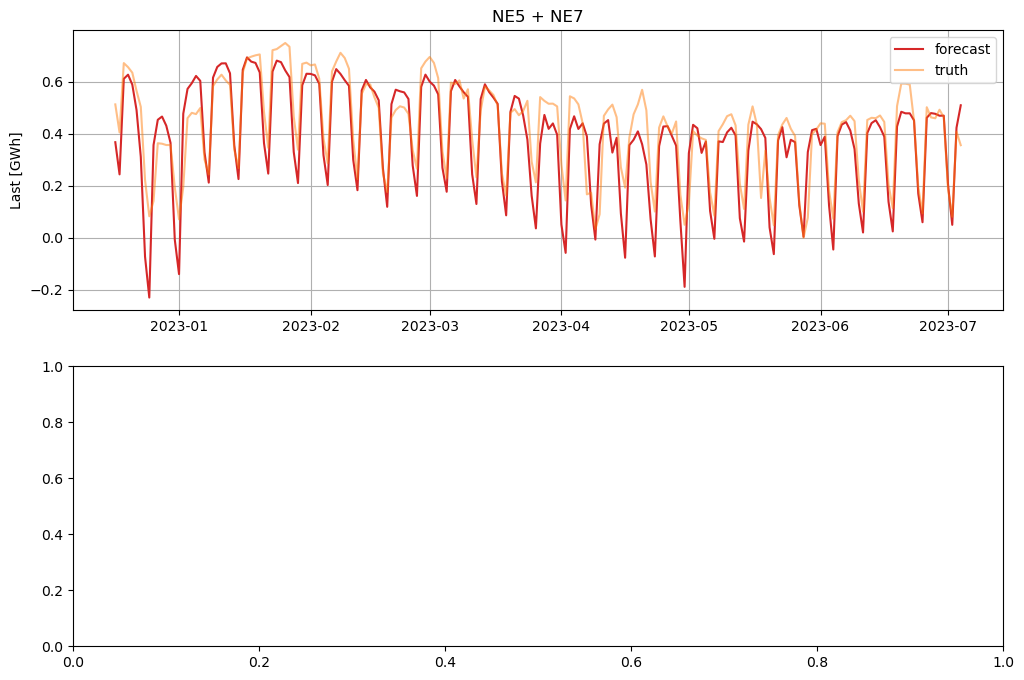

In [6]:
f, axes = plt.subplots(2, 1, figsize=(12, 8))


axes[0].plot(y_pred, color="tab:red", label="forecast")
# axes[0].plot(pdfTrain.ds.values, pdfTrain.y.values, color="tab:blue", label="train")
axes[0].plot(pdf_test, color="tab:orange", label="truth", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")
axes[0].grid()

# xmin, xmax = axes[0].get_xlim()

# axes[1].plot(pdf_test.index, (y_pred.values - pdf_test.y.values)*100) # / (pdf_test.y.values+y_pred.values)*100)
# axes[1].set_xlim(xmin, xmax)
# axes[1].set_ylabel("residual: (Pred-True)/True [%]")

plt.show()

In [7]:
print(f"RMSE: {mean_squared_error(y_pred, pdf_test.y.values, squared=False)}")


RMSE: 0.10207924510499634


In [11]:
# Wow this is really good for such a simple model!

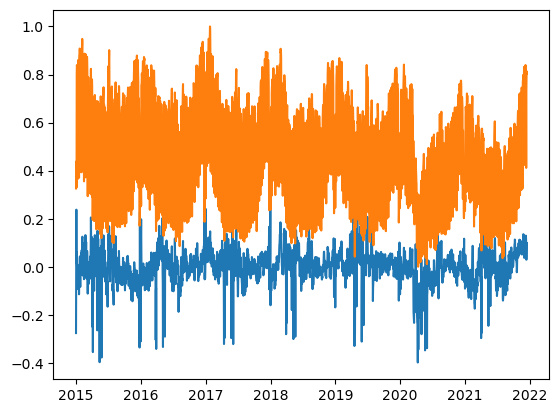

In [15]:
#How can i plot the individual components of the model?
plt.plot(forecaster.transform(pdf_train['y']))
plt.plot(pdf_train['y'])